In [1]:
import time
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score
)

In [ ]:
# Pull in receiving data
df = pd.read_csv('data/grower-pool-scores-v4.csv', dtype={'growerfamousid': str})
df['growerfamousid'] = df['growerfamousid'].str.replace('[^0-9.]', '', regex=True)
df['growerfamousid'] = pd.to_numeric(df['growerfamousid'], errors='coerce') 
df.head()

,datereceived,cropyear,quantity,qccount,blockid,organic,commodity,variety,growerfamousid,growerid,...,avg_frozen,avg_tiacidity,avg_lightexposure,pool,bitterpit,decay,soft,scald,internalbrowning,samplesize
0,2013-08-14 12:06:04.000,2013,6,5.0,14-GA-1,N,Apple,Gala,14.0,1,...,0.0,0.0,0.0,REG,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-08-14 15:26:35.000,2013,52,NaN,14-GA-1,N,Apple,Gala,14.0,1,...,NaN,NaN,NaN,REG,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-08-14 15:27:09.000,2013,52,NaN,14-GA-1,N,Apple,Gala,14.0,1,...,NaN,NaN,NaN,REG,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-08-13 00:00:00.000,2013,52,9.0,14-GA-1,N,Apple,Gala,14.0,1,...,0.0,0.0,0.0,REG,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-08-13 00:00:00.000,2013,55,NaN,14-GA-1,N,Apple,Gala,14.0,1,...,NaN,NaN,NaN,REG,NaN,NaN,NaN,NaN,NaN,NaN


### Clean Up Data

In [30]:
# Loop through the columns and check for null values
for column in df.columns:
    null_count = df[column].isnull().sum()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} null values.")

Column 'qccount' has 17899 null values.
Column 'growerfamousid' has 9 null values.
Column 'storagetype' has 19779 null values.
Column 'avg_size' has 17832 null values.
Column 'avg_temp' has 17832 null values.
Column 'avg_weight' has 17832 null values.
Column 'avg_starch' has 17832 null values.
Column 'avg_pressure' has 17832 null values.
Column 'avg_split' has 17832 null values.
Column 'avg_watercore' has 17832 null values.
Column 'avg_frozen' has 17832 null values.
Column 'avg_tiacidity' has 17832 null values.
Column 'avg_lightexposure' has 17832 null values.
Column 'bitterpit' has 7952 null values.
Column 'decay' has 7952 null values.
Column 'soft' has 7952 null values.
Column 'scald' has 7952 null values.
Column 'internalbrowning' has 7952 null values.
Column 'samplesize' has 7952 null values.


In [31]:
# Fill in qccount with average of the column if null
df['qccount'] = df['qccount'].fillna(df['qccount'].mean())

In [32]:
# # Drop storagetype
df = df.drop(columns=['storagetype'])

In [33]:
# Update pool scores for normalization
# If pool is 13GACL3 assign it to LATE
df.loc[df['pool'] == '13GACL3', 'pool'] = 'LATE'
df.loc[df['pool'] == '13GALC3', 'pool'] = 'LATE'
df.loc[df['pool'] == '13GDCL3', 'pool'] = 'LATE'
df.loc[df['pool'] == '17RDOAC1', 'pool'] = 'MID'
df.loc[df['pool'] == '19OPLC', 'pool'] = 'MID'
df.loc[df['pool'] == 'CE1', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'OCE1', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'AE2', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'OCEA1', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'R3', 'pool'] = 'REG'

# Drop records with this pool
df = df[~df['pool'].isin(['19FJCSTDM', '19OFJCSTDM', 'OCA'])]


In [34]:
# Update avg_size, avg_temp, avg_weight, avg_starch, avg_pressure, avg_split, avg_watercore, avg_frozen, avg_tiacidity, and avg_lightexposure with averages of the same pool
df['avg_size'] = df.groupby(['pool', 'growerid', 'variety'])['avg_size'].transform(lambda x: x.fillna(x.mean()))
df['avg_size'] = df.groupby(['pool', 'growerid'])['avg_size'].transform(lambda x: x.fillna(x.mean()))
df['avg_size'] = df.groupby('pool')['avg_size'].transform(lambda x: x.fillna(x.mean()))

df['avg_temp'] = df.groupby(['pool', 'growerid', 'variety'])['avg_temp'].transform(lambda x: x.fillna(x.mean()))
df['avg_temp'] = df.groupby(['pool', 'growerid'])['avg_temp'].transform(lambda x: x.fillna(x.mean()))
df['avg_temp'] = df.groupby('pool')['avg_temp'].transform(lambda x: x.fillna(x.mean()))

df['avg_weight'] = df.groupby(['pool', 'growerid', 'variety'])['avg_weight'].transform(lambda x: x.fillna(x.mean()))
df['avg_weight'] = df.groupby(['pool', 'growerid'])['avg_weight'].transform(lambda x: x.fillna(x.mean()))
df['avg_weight'] = df.groupby('pool')['avg_weight'].transform(lambda x: x.fillna(x.mean()))

df['avg_starch'] = df.groupby(['pool', 'growerid', 'variety'])['avg_starch'].transform(lambda x: x.fillna(x.mean()))
df['avg_starch'] = df.groupby(['pool', 'growerid'])['avg_starch'].transform(lambda x: x.fillna(x.mean()))
df['avg_starch'] = df.groupby('pool')['avg_starch'].transform(lambda x: x.fillna(x.mean()))

df['avg_pressure'] = df.groupby(['pool', 'growerid', 'variety'])['avg_pressure'].transform(lambda x: x.fillna(x.mean()))
df['avg_pressure'] = df.groupby(['pool', 'growerid'])['avg_pressure'].transform(lambda x: x.fillna(x.mean()))
df['avg_pressure'] = df.groupby('pool')['avg_pressure'].transform(lambda x: x.fillna(x.mean()))

df['avg_split'] = df.groupby(['pool', 'growerid', 'variety'])['avg_split'].transform(lambda x: x.fillna(x.mean()))
df['avg_split'] = df.groupby(['pool', 'growerid'])['avg_split'].transform(lambda x: x.fillna(x.mean()))
df['avg_split'] = df.groupby('pool')['avg_split'].transform(lambda x: x.fillna(x.mean()))

df['avg_watercore'] = df.groupby(['pool', 'growerid', 'variety'])['avg_watercore'].transform(lambda x: x.fillna(x.mean()))
df['avg_watercore'] = df.groupby(['pool', 'growerid'])['avg_watercore'].transform(lambda x: x.fillna(x.mean()))
df['avg_watercore'] = df.groupby('pool')['avg_watercore'].transform(lambda x: x.fillna(x.mean()))

df['avg_frozen'] = df.groupby(['pool', 'growerid', 'variety'])['avg_frozen'].transform(lambda x: x.fillna(x.mean()))
df['avg_frozen'] = df.groupby(['pool', 'growerid'])['avg_frozen'].transform(lambda x: x.fillna(x.mean()))
df['avg_frozen'] = df.groupby('pool')['avg_frozen'].transform(lambda x: x.fillna(x.mean()))

df['avg_tiacidity'] = df.groupby(['pool', 'growerid', 'variety'])['avg_tiacidity'].transform(lambda x: x.fillna(x.mean()))
df['avg_tiacidity'] = df.groupby(['pool', 'growerid'])['avg_tiacidity'].transform(lambda x: x.fillna(x.mean()))
df['avg_tiacidity'] = df.groupby('pool')['avg_tiacidity'].transform(lambda x: x.fillna(x.mean()))

df['avg_lightexposure'] = df.groupby(['pool', 'growerid', 'variety'])['avg_lightexposure'].transform(lambda x: x.fillna(x.mean()))
df['avg_lightexposure'] = df.groupby(['pool', 'growerid'])['avg_lightexposure'].transform(lambda x: x.fillna(x.mean()))
df['avg_lightexposure'] = df.groupby('pool')['avg_lightexposure'].transform(lambda x: x.fillna(x.mean()))

In [35]:
# Create a new cull_percent column
df['cull_percent'] = (df['bitterpit'] + df['decay'] + df['soft'] + df['scald'] + df['internalbrowning'])/ df['samplesize'] * 100
# Drop the original columns
df = df.drop(columns=['bitterpit', 'decay', 'soft', 'scald', 'internalbrowning'])
# Drop the samplecount column
df = df.drop(columns=['samplesize'])

# Fill in cull_percent with average of the column if null
df['cull_percent'] = df.groupby(['pool', 'growerid', 'variety'])['cull_percent'].transform(lambda x: x.fillna(x.mean()))
df['cull_percent'] = df.groupby(['pool', 'growerid'])['cull_percent'].transform(lambda x: x.fillna(x.mean()))
df['cull_percent'] = df.groupby('pool')['cull_percent'].transform(lambda x: x.fillna(x.mean()))

In [36]:
# Check the percentages of REG, EARLY, MID, and LATE
percentages = df['pool'].value_counts(normalize=True) * 100
print(percentages)

pool
LATE     33.816379
MID      23.213993
EARLY    21.961861
REG      21.007767
Name: proportion, dtype: float64


## Business Objective
The purpose of this work is to properly qualify the bins of fruit to either REG, EARLY, MID, OR LATE. This will allow us to minimize the impact of having culls that are related to keeping the fruit in a CA room for too long.

#### Encode the columns

In [37]:
def encode(df):
    # Encode the target column 'y'
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['pool'])
    print(label_encoder.classes_)
    X = df.drop(columns=['pool'], axis=1)

    # Encode all categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns
    numerical_columns = X.select_dtypes(include=['number']).columns

    # Encode categorical columns
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

    # Encode numerical columns
    scaler = StandardScaler()
    X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    return X, y

X, y = encode(df)

['EARLY' 'LATE' 'MID' 'REG']


In [38]:
##### Trim down X due to time constraints
# Add in all avg columns plus variety columns
X_trimmed = X[['cropyear', 'growerid', 'avg_size', 'avg_temp', 'avg_weight', 'avg_starch', 'avg_pressure', 'avg_split', 'avg_watercore', 'avg_frozen', 'avg_tiacidity', 'avg_lightexposure', 'cull_percent']]

# Add in all variety columns
variety_columns = [col for col in X.columns if 'variety_' in col]
X_trimmed = pd.concat([X_trimmed, X[variety_columns]], axis=1)

# Add in all block columns
variety_columns = [col for col in X.columns if 'blockid_' in col]
X_trimmed = pd.concat([X_trimmed, X[variety_columns]], axis=1)


#### Split Test Data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_trimmed, y, test_size=0.3, random_state=42
)

In [40]:
# Assign and define class weights
class_weights = {3: 0.5,  # REG gets a lower weight because we have market price influence when it comes to selecting packing right away
                 0: 1.0,
                 2: 1.0,
                 1: 1.0}

### Set Up Baseline Model

In [47]:
dummy = DummyClassifier(strategy="most_frequent",)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
baseline_acc = accuracy_score(y_test, dummy_pred)

print(classification_report(y_test, dummy_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10442
           1       0.34      1.00      0.51     16055
           2       0.00      0.00      0.00     11018
           3       0.00      0.00      0.00      9996

    accuracy                           0.34     47511
   macro avg       0.08      0.25      0.13     47511
weighted avg       0.11      0.34      0.17     47511



#### Go through key models

In [42]:
start_time = time.time()
lr = LogisticRegression(class_weight=class_weights, max_iter=1000)
lr.fit(X_train, y_train)
lr_train_time = time.time() - start_time
print(f"Training time: {lr_train_time:.4f} seconds")

lr_pred = lr.predict(X_test)
lr_acc_test = accuracy_score(y_test, lr_pred)
lr_acc_train = accuracy_score(y_train, lr.predict(X_train))
lr_precision_score = precision_score(y_test, lr_pred, average='weighted')
lr_recall_score = recall_score(y_test, lr_pred, average='weighted')

print(classification_report(y_test, lr_pred))

Training time: 49.1345 seconds
              precision    recall  f1-score   support

           0       0.59      0.63      0.61     10442
           1       0.64      0.83      0.72     16055
           2       0.51      0.43      0.47     11018
           3       0.87      0.54      0.66      9996

    accuracy                           0.63     47511
   macro avg       0.65      0.61      0.61     47511
weighted avg       0.65      0.63      0.62     47511



In [16]:
start_time = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_train_time = time.time() - start_time
print(f"Training time: {knn_train_time:.4f} seconds")

knn_pred = knn.predict(X_test)
knn_acc_test = accuracy_score(y_test, knn_pred)
knn_acc_train = accuracy_score(y_train, knn.predict(X_train))
print(classification_report(y_test, knn_pred))

Training time: 1.8125 seconds
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     10442
           1       0.89      0.92      0.90     16055
           2       0.83      0.83      0.83     11018
           3       0.93      0.86      0.89      9996

    accuracy                           0.87     47511
   macro avg       0.87      0.87      0.87     47511
weighted avg       0.87      0.87      0.87     47511



In [17]:
# start_time = time.time()
# svc = SVC(class_weight=class_weights)
# svc.fit(X_train, y_train)
# svc_train_time = time.time() - start_time
# print(f"Training time: {svc_train_time:.4f} seconds")

# svc_pred = svc.predict(X_test)
# svc_acc_test = accuracy_score(y_test, svc_pred)
# svc_acc_train = accuracy_score(y_train, svc.predict(X_train))
# print(classification_report(y_test, svc_pred))

In [18]:
start_time = time.time()
dt = DecisionTreeClassifier(class_weight=class_weights)
dt.fit(X_train, y_train)
dt_train_time = time.time() - start_time
print(f"Training time: {dt_train_time:.4f} seconds")

dt_pred = dt.predict(X_test)
dt_acc_test = accuracy_score(y_test, dt_pred)
dt_acc_train = accuracy_score(y_train, dt.predict(X_train))
print(classification_report(y_test, dt_pred))

Training time: 3.5920 seconds
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10442
           1       0.93      0.94      0.94     16055
           2       0.89      0.90      0.89     11018
           3       0.92      0.90      0.91      9996

    accuracy                           0.91     47511
   macro avg       0.91      0.91      0.91     47511
weighted avg       0.91      0.91      0.91     47511



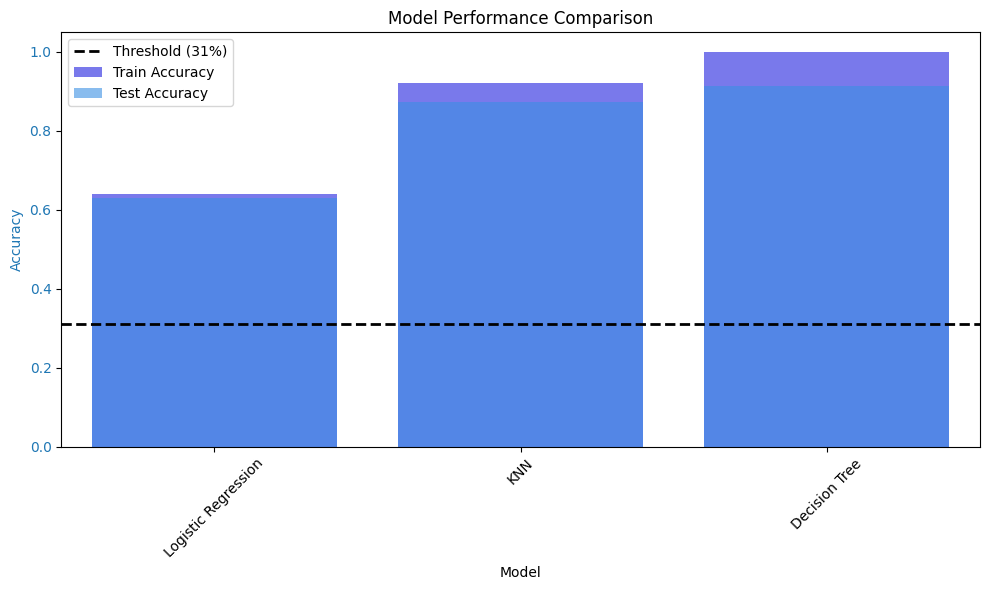

<Figure size 640x480 with 0 Axes>

In [19]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "Decision Tree"],
    "Train Time (s)": [lr_train_time, knn_train_time, dt_train_time],
    "Train Accuracy": [lr_acc_train, knn_acc_train, dt_acc_train],
    "Test Accuracy": [lr_acc_test, knn_acc_test, dt_acc_test]
})

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Accuracy (Train & Test) on left y-axis
ax1.set_title("Model Performance Comparison")
ax1.set_xlabel("Model")
ax1.set_ylabel("Accuracy", color="tab:blue")
sns.barplot(data=results, x="Model", y="Train Accuracy", color="blue", alpha=0.6, label="Train Accuracy", ax=ax1)
sns.barplot(data=results, x="Model", y="Test Accuracy", color="dodgerblue", alpha=0.6, label="Test Accuracy", ax=ax1)
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add threshold line for accuracy at 88.76%
ax1.axhline(y=31 / 100, color="black", linestyle="--", linewidth=2, label="Threshold (31%)")

# Legends
ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('./images/initial_model_performance_comparison.png')

#### Use enhancing techniques on the models

In [20]:
# Go through the different models of SVC
# params = { 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
# svc = SVC(class_weight=class_weights)
# grid_search = GridSearchCV(estimator=svc, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)
# svc_precision_score = precision_score(y_test, grid_search.predict(X_test), average='weighted')
# print("Precision Score: ", svc_precision_score)
# svc_recall_score = recall_score(y_test, grid_search.predict(X_test), average='weighted')
# print("Recall Score: ", svc_recall_score)

In [21]:
params = { 'max_depth': [2, 5, 10, 15, 20]}
dt = DecisionTreeClassifier(class_weight=class_weights)
grid_search = GridSearchCV(estimator=dt, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

dt_precision_score = precision_score(y_test, grid_search.predict(X_test), average='weighted')
print("Precision Score: ", dt_precision_score)
dt_recall_score = recall_score(y_test, grid_search.predict(X_test), average='weighted')
print("Recall Score: ", dt_recall_score)

{'max_depth': 20}
0.8289899792628359
Precision Score:  0.8476020682232607
Recall Score:  0.8442045000105238


In [22]:
params = {'n_neighbors': [2, 5, 10, 12, 15]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

knn_precision_score = precision_score(y_test, grid_search.predict(X_test), average='weighted')
print("Precision Score: ", knn_precision_score)
knn_recall_score = recall_score(y_test, grid_search.predict(X_test), average='weighted')
print("Recall Score: ", knn_recall_score)

{'n_neighbors': 2}
0.8840419146106517
Precision Score:  0.9053602957841439
Recall Score:  0.901854307423544


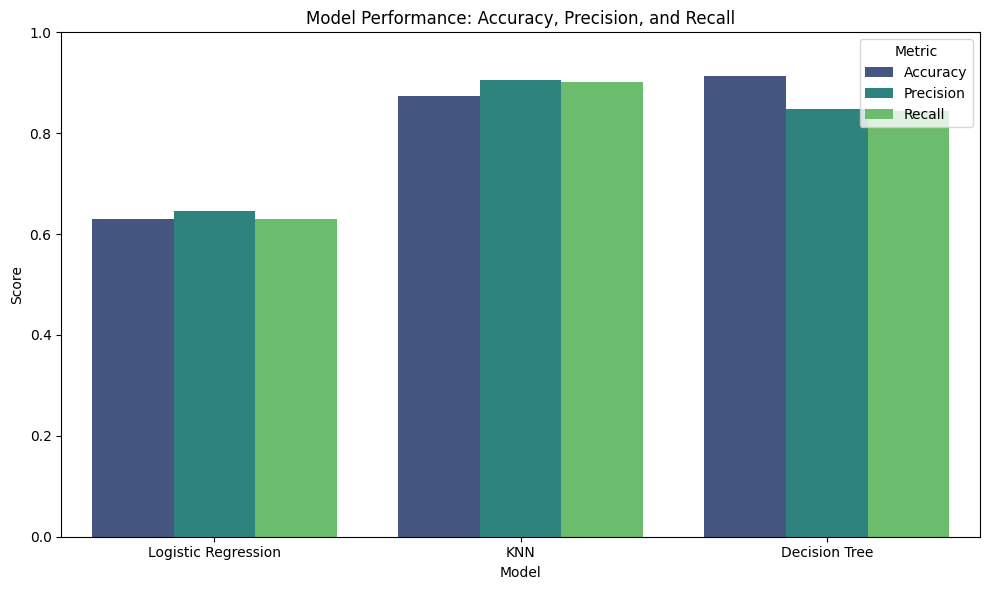

<Figure size 640x480 with 0 Axes>

In [23]:
stacked_data = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "Decision Tree"],
    "Accuracy": [lr_acc_test, knn_acc_test, dt_acc_test],
    "Precision": [lr_precision_score, knn_precision_score, dt_precision_score],
    "Recall": [lr_recall_score, knn_recall_score, dt_recall_score]
})

# Melt the data for easier plotting
stacked_data_melted = stacked_data.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create the stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=stacked_data_melted, x="Model", y="Score", hue="Metric", palette="viridis")

# Add labels and title
plt.title("Model Performance: Accuracy, Precision, and Recall")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(title="Metric", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('./images/results.png')

# Ensemble Models

In [15]:
# Assuming X_train_scaled and y_train
model = RandomForestClassifier(class_weight=class_weights, n_estimators=100, random_state=42, n_jobs=-1) # Use all cores
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Select top N important features
top_n = 10
selected_features_importance = [item[0] for item in sorted_feature_importance[:top_n]]
print("Top", top_n, "important features:", selected_features_importance)

# Filter your training and testing data to include only these selected features
X_train_selected = X_train[selected_features_importance]
X_test_selected = X_test[selected_features_importance]

pred = model.predict(X_test)
acc_test = accuracy_score(y_test, pred)
acc_train = accuracy_score(y_train, model.predict(X_train))
print(classification_report(y_test, pred, target_names=['EARLY', 'LATE', 'MID', 'REG']))
print(f"Random Forest Accuracy: {acc_test:.4f}")
print(f"Random Forest Accuracy (train): {acc_train:.4f}")

Top 10 important features: ['avg_starch', 'avg_pressure', 'cropyear', 'avg_weight', 'cull_percent', 'growerid', 'avg_tiacidity', 'avg_watercore', 'blockid_26', 'variety_Gala']
              precision    recall  f1-score   support

       EARLY       0.95      0.94      0.95     10442
        LATE       0.95      0.97      0.96     16055
         MID       0.94      0.93      0.94     11018
         REG       0.97      0.95      0.96      9996

    accuracy                           0.95     47511
   macro avg       0.95      0.95      0.95     47511
weighted avg       0.95      0.95      0.95     47511

Random Forest Accuracy: 0.9522
Random Forest Accuracy (train): 0.9991


PermutationExplainer explainer: 1001it [03:13,  4.91it/s]                          


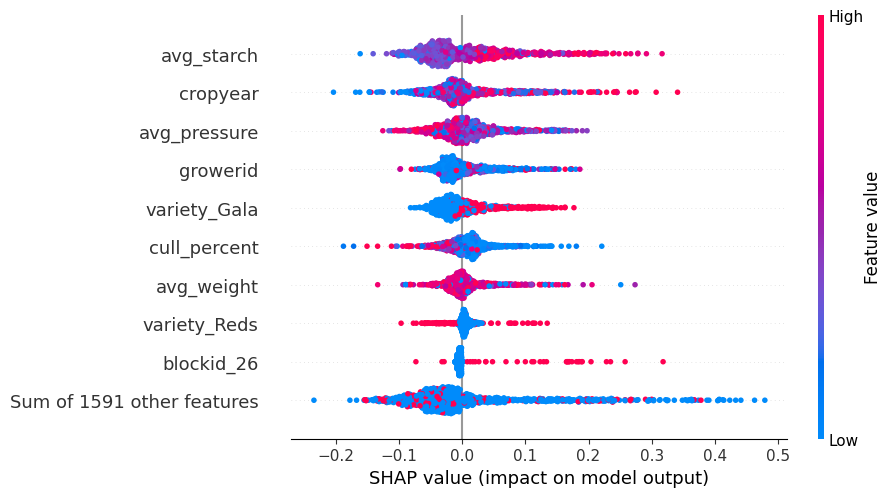

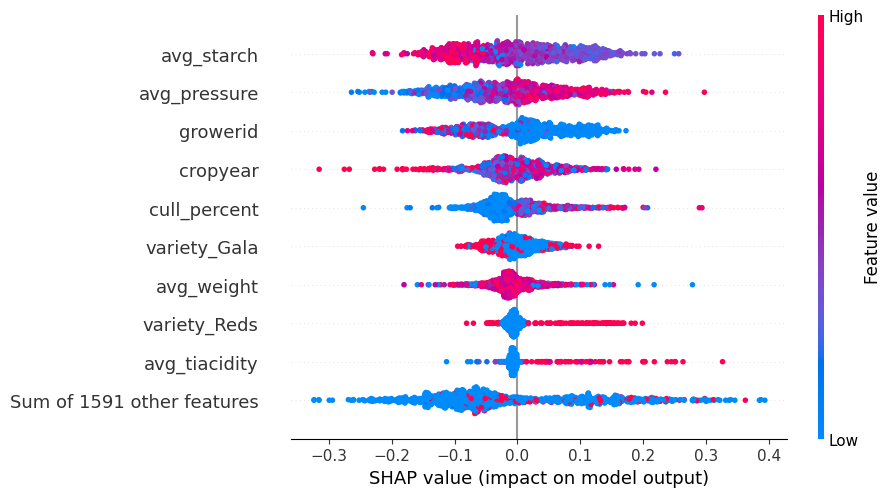

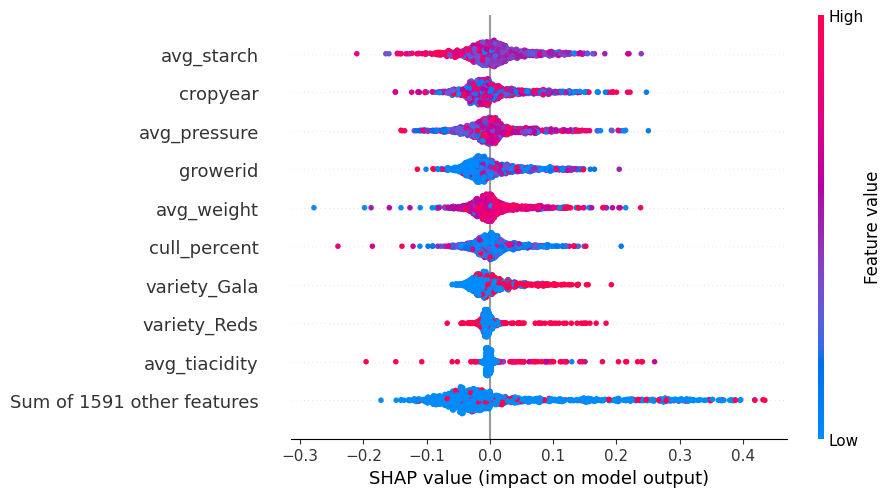

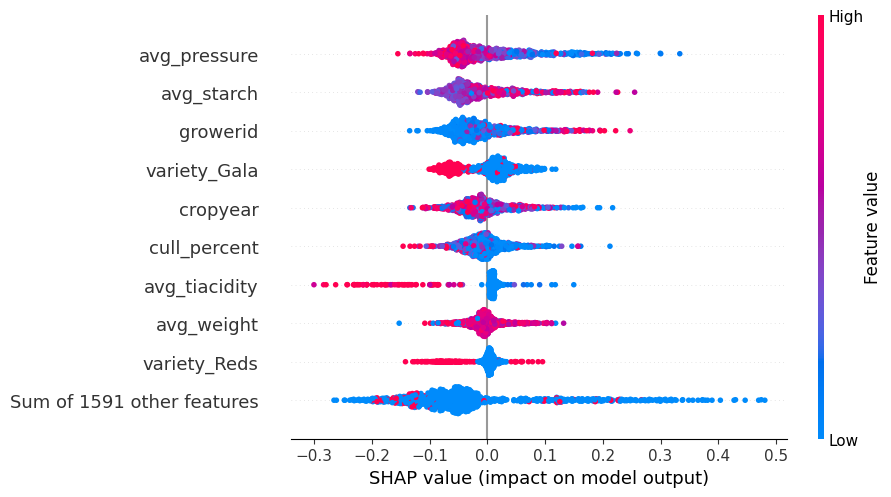

In [24]:
# --- SHAP Analysis ---
# Ensure all columns in X_train and X_test are numeric
X_train_numeric = X_train.copy()
X_test_numeric = X_test.copy()
X_train_numeric = X_train_numeric.astype({col: 'float64' for col in X_train_numeric.select_dtypes(include=['bool']).columns})
X_test_numeric = X_test_numeric.astype({col: 'float64' for col in X_test_numeric.select_dtypes(include=['bool']).columns})

# 1. Create a SHAP explainer
explainer = shap.Explainer(model.predict_proba, X_train_numeric)  # Use 'predict_proba' for numeric outputs

# 2. Calculate SHAP values for the test set
# Utilize a sample of the test set for SHAP analysis
X_test_sample = X_test_numeric.sample(n=1000, random_state=42)  # Sample 1000 rows from the test set
shap_values = explainer(X_test_sample)

# --- Visualization ---
# Visualize feature importance
# Select a specific output dimension (e.g., class 0) for the SHAP values
shap_values_class_0 = shap_values[..., 0]  # Replace 0 with the desired class index

# Visualize feature importance using bar plot
shap.plots.beeswarm(shap_values_class_0)

# Do the other feature importance plots
shap_values_class_1 = shap_values[..., 1]  # Replace 1 with the desired class index
shap.plots.beeswarm(shap_values_class_1)
shap_values_class_2 = shap_values[..., 2]  # Replace 2 with the desired class index
shap.plots.beeswarm(shap_values_class_2)
shap_values_class_3 = shap_values[..., 3]  # Replace 3 with the desired class index
shap.plots.beeswarm(shap_values_class_3)

In [ ]:
# Create an XGBoost classifier
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    class_weight=class_weights,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1
)
# Fit the model
xgb_model.fit(X_train, y_train)
# Make predictions
xgb_pred = xgb_model.predict(X_test)
# Evaluate the model
xgb_acc_test = accuracy_score(y_test, xgb_pred)
xgb_acc_train = accuracy_score(y_train, xgb_model.predict(X_train))
print(f"XGBoost Accuracy: {xgb_acc_test:.4f}")
print(f"XGBoost Accuracy (train): {xgb_acc_train:.4f}")
xgb_precision_score = precision_score(y_test, xgb_pred, average='weighted')
print("Precision Score: ", xgb_precision_score)
xgb_recall_score = recall_score(y_test, xgb_pred, average='weighted')
print("Recall Score: ", xgb_recall_score)
print(classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))
# Feature importance
xgb_importances = xgb_model.feature_importances_
xgb_feature_importance_dict = dict(zip(X_train.columns, xgb_importances))
sorted_xgb_feature_importance = sorted(xgb_feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
# Select top N important features
selected_xgb_features_importance = [item[0] for item in sorted_xgb_feature_importance[:top_n]]
print("Top", top_n, "important features:", selected_xgb_features_importance)

/Users/ethan.florygilbertfruit.com/Documents/Repos/Berkely_Capstone/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight", "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7106
XGBoost Accuracy (train): 0.7170
Precision Score:  0.7110128492106917
Recall Score:  0.7106143840373809
              precision    recall  f1-score   support

       EARLY       0.74      0.61      0.67     10442
        LATE       0.70      0.88      0.78     16055
         MID       0.67      0.52      0.59     11018
         REG       0.75      0.76      0.75      9996

    accuracy                           0.71     47511
   macro avg       0.71      0.69      0.70     47511
weighted avg       0.71      0.71      0.70     47511

Top 10 important features: ['blockid_89-FJ-O', 'blockid_26', 'blockid_20-PL-E', 'avg_tiacidity', 'variety_Gala', 'growerid', 'blockid_7042-PL', 'variety_Pink Lady', 'avg_watercore', 'blockid_9966-GS-O']


In [ ]:
# LightGBM
lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    class_weight=class_weights,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1
)
# Sanitize feature names to remove special characters
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

# Fit the model
lgbm_model.fit(X_train, y_train)
# Make predictions
lgbm_pred = lgbm_model.predict(X_test)
# Evaluate the model
lgbm_acc_test = accuracy_score(y_test, lgbm_pred)
lgbm_acc_train = accuracy_score(y_train, lgbm_model.predict(X_train))
lgbm_precision_score = precision_score(y_test, lgbm_pred, average='weighted')
lgbm_recall_score = recall_score(y_test, lgbm_pred, average='weighted')
print(classification_report(y_test, lgbm_pred, target_names=label_encoder.classes_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3225
[LightGBM] [Info] Number of data points in the train set: 110859, number of used features: 808
[LightGBM] [Info] Start training from score -1.405280
[LightGBM] [Info] Start training from score -0.973019
[LightGBM] [Info] Start training from score -1.349080
[LightGBM] [Info] Start training from score -2.143170
              precision    recall  f1-score   support

       EARLY       0.73      0.76      0.74     10442
        LATE       0.77      0.90      0.83     16055
         MID       0.73      0.67      0.70     11018
         REG       0.92      0.70      0.80      9996

    accuracy                           0.77     47511
   macro avg       0.79      0.76      0.77     47511
weighted avg       0.78      0.77      0.77     4